In [22]:
#1.Import Libaries
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

In [23]:
#2.Loading processed CSV
import pandas as pd

df = pd.read_csv("../data/processed/cicids_clean.csv", low_memory=False)
df["Label"] = df["Label"].map({"Benign": 0, "Bot": 1})

In [46]:
#Split X and y
X = df.drop(columns=["Label"])
y = df["Label"]



In [47]:
import numpy as np

non_num_cols = X.select_dtypes(exclude=[np.number]).columns
non_num_cols


Index(['Timestamp'], dtype='object')

In [48]:
X = X.drop(columns=non_num_cols)


In [49]:
X.select_dtypes(exclude=[np.number]).columns


Index([], dtype='object')

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:
#Training Model A: Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
lr.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


ROC-AUC: 0.9977663291586508
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3942
           1       1.00      1.00      1.00     15944

    accuracy                           1.00     19886
   macro avg       1.00      0.99      0.99     19886
weighted avg       1.00      1.00      1.00     19886



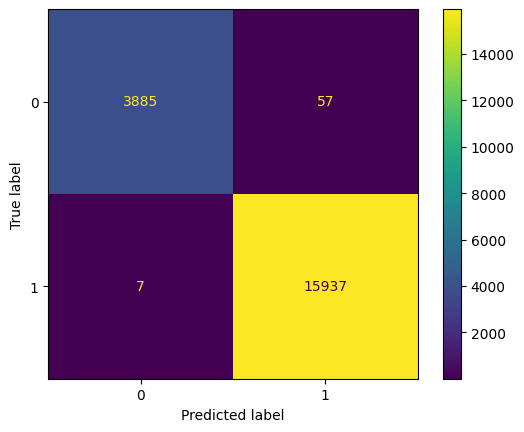

In [53]:
#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()


In [54]:
#Training Model B: Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


ROC-AUC: 0.9999999363576678
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3942
           1       1.00      1.00      1.00     15944

    accuracy                           1.00     19886
   macro avg       1.00      1.00      1.00     19886
weighted avg       1.00      1.00      1.00     19886



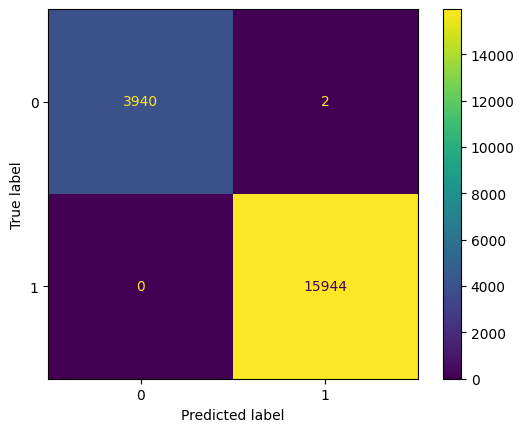

In [55]:
#Evaluate Random Forest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()
plt.show()


In [57]:
#Adding one more metric: False Positive Rate
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("FPR:", fpr)
print("FNR:", fnr)


FPR: 0.0005073566717402334
FNR: 0.0


In [58]:
#Saving the Baseline Artifacts
import joblib
joblib.dump(rf, "../models/rf_baseline.joblib")
joblib.dump(lr, "../models/lr_baseline.joblib")
joblib.dump(scaler, "../models/standard_scaler.joblib")


['../models/standard_scaler.joblib']

In [59]:
import pandas as pd

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(15)


Dst Port             0.144481
Fwd IAT Tot          0.089239
Flow IAT Mean        0.088224
Flow Pkts/s          0.079609
Fwd Pkts/s           0.065966
Fwd IAT Mean         0.059122
Bwd Seg Size Avg     0.051709
Fwd IAT Max          0.051161
Flow Duration        0.043026
Bwd Pkt Len Mean     0.039567
Fwd IAT Min          0.036993
Flow IAT Max         0.027328
Init Fwd Win Byts    0.021156
Subflow Fwd Pkts     0.019284
Flow IAT Std         0.018312
dtype: float64